## Evaluating generative text models

### Using GPT to generate text

In [1]:
import torch
from utils.gpt_model import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # Shortening the context length from 1024 to 256 tokens
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [2]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [25]:
import tiktoken

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Keep only the last context_size tokens

        with torch.no_grad(): # Disable gradient calculation because that is just inefficient for this purpose
            logits = model(idx_cond)

        # Get the last token's logits
        logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size). Last row.
        probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # Get the index of the most probable token

        # Append the predicted token to the input sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())


In [27]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

output_token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(output_token_ids, tokenizer))

Output text:
 Every effort moves you Ti fantasy Robin executions appearタ perhaps constitutionallyrawling immediately


### Calculating the text generation loss

In [5]:
# Two input examples for text generation

inputs = torch.tensor([
    [16833, 3626, 6100], # "Every effort moves you"
    [40,    1107, 588]   # "I really like"
])

# Targets matching the inputs we want the model to predict
targets = torch.tensor([
    [3626, 6100, 345],   # "effort moves you"
    [1107, 588, 11311]   # "really like chocolate"
])

In [6]:
# Generate model output for the inputs
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
print(probas.shape)  # Should be (2, 3, 50257) for batch size 2, sequence length 3, vocab size 50257

torch.Size([2, 3, 50257])


In [7]:
# Apply argmax to get the most probable token ids
token_ids = torch.argmax(probas, dim=-1, keepdim=True)  # Shape: (2, 3, 1)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
# Convert token IDs back into text
print(f"Target batch1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Target batch1:  effort moves you
Outputs batch1:  Armed heNetflix


In [9]:
# Initial softmax probability scores corresponding to the target tokens
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # Look up to the probablity scores at indexes 3626, 6100 and 345
print(f"Target probabilities for batch1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]] # Similarly for the second batch
print(f"Target probabilities for batch2: {target_probas_2}")

Target probabilities for batch1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Target probabilities for batch2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
# Apply logarithm to the probability scores
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
# Average the log probabilities
avg_log_probas = log_probas.mean()
print(f"Average log probability: {avg_log_probas.item()}")

Average log probability: -10.793964385986328


In [12]:
# Negative average log probability
neg_avg_log_probas = -avg_log_probas
print(f"Negative average log probability: {neg_avg_log_probas.item()}")

Negative average log probability: 10.793964385986328


In [13]:
# Shape of the logits and target tensors
print(f"Logits shape: {logits.shape}, Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257]), Targets shape: torch.Size([2, 3])


In [14]:
# For Pytorch's cross_entropy loss function, we need to reshape the logits and targets
logits_reshaped = logits.view(-1, logits.size(-1)) # Or we can use logits.flatten(0, 1)
logits_reshaped.shape  # Should be (batch_size * seq_length, vocab_size)


torch.Size([6, 50257])

In [15]:
targets_reshaped = targets.view(-1)  # Flatten the targets to match logits_reshaped
targets_reshaped.shape  # Should be (batch_size * seq_length,)

torch.Size([6])

In [16]:
loss = torch.nn.functional.cross_entropy(logits_reshaped, targets_reshaped)
print(f"Cross-entropy loss: {loss.item()}")

Cross-entropy loss: 10.793964385986328


In [17]:
perplexity = torch.exp(loss)
print(f"Perplexity: {perplexity.item()}")


Perplexity: 48725.8203125


### Calculating the training and validation set losses

In [18]:
# Take a small dataset "The Verdict" short story
file_path = "data/the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}, Total tokens: {total_tokens}")

Total characters: 20479, Total tokens: 5145


In [20]:
# Splitting the text into training and validation sets
train_ratio = 0.90 # Use 90% of the data for training and 10% for validation
split_index = int(len(text_data) * train_ratio)
train_data = text_data[:split_index]
val_data = text_data[split_index:]

In [21]:
# Creating data loaders for training and validation sets
from utils.data_loader import create_dataloader_v1

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [22]:
print("Train loader:")
for x, y in train_loader:
    print(f"Input batch shape: {x.shape}, Target batch shape: {y.shape}")

print("Validation loader:")
for x, y in val_loader:
    print(f"Input batch shape: {x.shape}, Target batch shape: {y.shape}")

Train loader:
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Validation loader:
Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])


In [23]:
# Verify number of tokens in the training and validation sets
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

total_tokens = train_tokens + val_tokens
print(f"Training tokens: {train_tokens}, Validation tokens: {val_tokens}, Total tokens: {total_tokens}")

Training tokens: 4608, Validation tokens: 512, Total tokens: 5120


In [24]:
# Utility function to calculate the cross-entropy loss of a given batch returned via training and validation loader

def calculate_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),  # Reshape logits to (batch_size * seq_length, vocab_size)
        target_batch.view(-1)  # Flatten targets to match logits
    )
    return loss

In [25]:
# Implement function to compute loss over all the batches sampled by a given data loader

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan") # Return NaN if the data loader is empty
    elif num_batches is None:
        num_batches = len(data_loader) # Iterate over all batches if num_batches is not specified
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break  # Stop after processing num_batches
        loss = calculate_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    
    avg_loss = total_loss / num_batches
    return avg_loss

In [26]:
torch.backends.mps.is_available()  # Check if MPS (Metal Performance Shaders) is available

True

MPS is Apple equivalent to CUDA. MPS will be faster than CPU. But MPS is newer so you might get slightly different results that CPU and CUDA. So let's use CPU in local device.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Transfer to given device (CPU or GPU) without modifying the code

with torch.no_grad():  # Disable gradient calculation because we are not training the model here
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Training loss: {train_loss}, Validation loss: {val_loss}")

Training loss: 10.987583796183268, Validation loss: 10.98110580444336


## Training an LLM

In [28]:
# A simple function for pretraning LLMs

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # Set the model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from the previous batch iteration
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights based on loss gradients
            tokens_seen += input_batch.numel()  # Count the number of tokens seen in this batch
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1}, (Step {global_step:06d}): Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [29]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # Set the model to evaluation mode. Dropout is disabled during evaluation for stable and reproducible results
    with torch.no_grad():  # Disable gradient calculation because we are not training the model here
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # Set the model back to training mode
    return train_loss, val_loss

In [30]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]  # Get the context size from the model's positional embedding
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [31]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)  # Transfer model to the specified device

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1, (Step 000000): Train Loss: 10.516, Val Loss: 10.574
Ep 1, (Step 000005): Train Loss: 9.127, Val Loss: 9.413
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2, (Step 000010): Train Loss: 8.670, Val Loss: 8.881
Ep 2, (Step 000015): Train Loss: 8.184, Val Loss: 8.408
Every effort moves you, the, the the the the the the the, the.                                     
Ep 3, (Step 000020): Train Loss: 7.601, Val Loss: 7.977
Ep 3, (Step 000025): Train Loss: 7.163, Val Loss: 7.576
Every effort moves you, the, the the the, the, the, the the, the, the, the the, the,, the, the, the the, the the the, the the the the, the the, the the, the, the,
Ep 4, (Step 000030): Train Loss: 6.676, Val Loss: 7.267
Ep 4, (Step 000035): Train Loss: 6.220, Val Loss: 6.997
Every effort moves you, the, and the the, the, the, the the. ", I had the, I, I had the, I had the, and the the, the the of the, and the, and the, and, the of
Ep 5, (Step 000040): Train Loss: 5.844, Val Loss: 6.850

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label='Training Loss')
    ax1.plot(epochs_seen, val_losses, label='Validation Loss', linestyle='-.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens Seen')
    fig.tight_layout()
    plt.show()


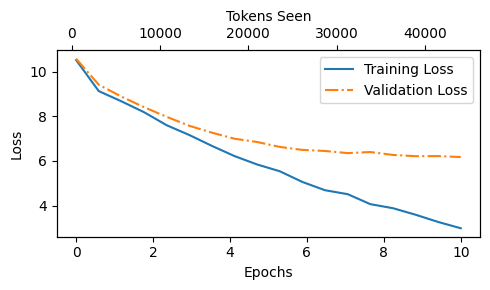

In [33]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

In [34]:
epochs_tensor

tensor([ 0.0000,  0.5882,  1.1765,  1.7647,  2.3529,  2.9412,  3.5294,  4.1176,
         4.7059,  5.2941,  5.8824,  6.4706,  7.0588,  7.6471,  8.2353,  8.8235,
         9.4118, 10.0000])

In [35]:
len(train_losses)

18

### Decoding strategies to control randomness

In [41]:
# Generate text using the trained model
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know he was not that my dear, I had the fact with a little a.










At this moment, everytime we run `generate_text_simple`, it gives us same output on the same start context

### Temperature scaling
A technique that adds a probabiistic selection of the next-token generated

In [46]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Assuming the LLM is given the start context "Every effort moves you" and generates the following next-token logits
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

# Convert logits to probabilities using softmax
probas = torch.softmax(next_token_logits, dim=0)

# Using greedy decoding to select the token with the highest probability
next_token_id = torch.argmax(probas).item()
next_token = inverse_vocab[next_token_id]
print(f"Greedy decoding selected token: {next_token}")

Greedy decoding selected token: forward


In [48]:
# Implementing a probabilistic sampling method, replace argmax with multinomial function in Pytorch
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()  # Sample a token based on the probabilities
next_token = inverse_vocab[next_token_id]
print(f"Probabilistic sampling selected token: {next_token}")


Probabilistic sampling selected token: toward


In [49]:
# Repearting the sampling 1000 times
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))

    for i, freq in enumerate(sampled_ids):
        print(f"Token: {inverse_vocab[i]}, Frequency: {freq}")

print_sampled_tokens(probas)

Token: closer, Frequency: 71
Token: every, Frequency: 2
Token: effort, Frequency: 0
Token: forward, Frequency: 544
Token: inches, Frequency: 2
Token: moves, Frequency: 1
Token: pizza, Frequency: 0
Token: toward, Frequency: 376
Token: you, Frequency: 4


In [50]:
# Controlling distribution and selection of next token via temperature scaling

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

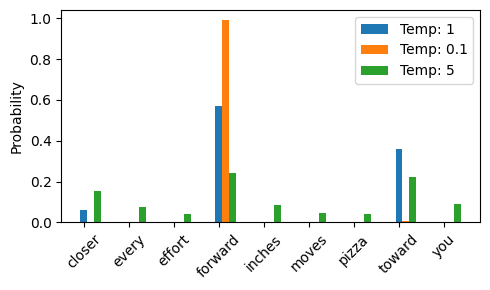

In [51]:
# Visualizing the effect of temperature scaling on the next-token probabilities
temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, temp) for temp in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, temp in enumerate(temperatures):
    ax.bar(x + i * bar_width, scaled_probas[i], width=bar_width, label=f'Temp: {temp}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [56]:
print_sampled_tokens(scaled_probas[0])  # Sampling with temperature 1

Token: closer, Frequency: 71
Token: every, Frequency: 2
Token: effort, Frequency: 0
Token: forward, Frequency: 544
Token: inches, Frequency: 2
Token: moves, Frequency: 1
Token: pizza, Frequency: 0
Token: toward, Frequency: 376
Token: you, Frequency: 4


In [57]:
print_sampled_tokens(scaled_probas[1])  # Sampling with temperature 0.1

Token: closer, Frequency: 0
Token: every, Frequency: 0
Token: effort, Frequency: 0
Token: forward, Frequency: 992
Token: inches, Frequency: 0
Token: moves, Frequency: 0
Token: pizza, Frequency: 0
Token: toward, Frequency: 8


In [59]:
print_sampled_tokens(scaled_probas[2])  # Sampling with temperature 5

Token: closer, Frequency: 153
Token: every, Frequency: 68
Token: effort, Frequency: 55
Token: forward, Frequency: 223
Token: inches, Frequency: 102
Token: moves, Frequency: 50
Token: pizza, Frequency: 43
Token: toward, Frequency: 218
Token: you, Frequency: 88


### Topk-K Sampling

In [60]:
topp_k = 3  # Top-k value for top-k sampling

top_logits, top_pos = torch.topk(next_token_logits, topp_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [61]:
# Mask the logits to keep only the top-k values
new_logits = torch.where(next_token_logits >= top_logits[-1], next_token_logits, torch.tensor(float('-inf')))
print("Masked logits:", new_logits)

Masked logits: tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [62]:
# Apply softmax to the masked logits
topk_probas = torch.softmax(new_logits, dim=0)
print("Top-k probabilities:", topk_probas)

Top-k probabilities: tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Modifying the text generation function with Temperature Scaling and Top-K Sampling

In [23]:
# A modified text generation function with more diversity in the output
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Keep only the last context_size tokens

        with torch.no_grad():
            logits = model(idx_cond)
        # Get the last token's logits
        logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size). Last row.

        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits >= min_val, logits, torch.tensor(float('-inf')).to(logits.device))

        if temperature > 0.0:  # This also avoids division by zero
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break  # Stop if the end-of-sequence token is generated
        idx = torch.cat((idx, idx_next), dim=1)  # Append the predicted token to the input sequence

    return idx

In [64]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know the, in a good _ I it was no
"I was


### Loading and saving model weights in PyTorch

In [65]:
# Save the model weights to a file
torch.save(model.state_dict(), "model.pth")

In [72]:
# Load the model weights to a new model instance
new_model = GPTModel(GPT_CONFIG_124M)
new_model.load_state_dict(torch.load("model.pth", map_location=device))
new_model.eval();

In [68]:
# We can also save both model and optimizer states
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "model_and_optimizer.pth")

In [70]:
# Restore the model and optimizer states
checkpoint = torch.load("model_and_optimizer.pth")
new_model = GPTModel(GPT_CONFIG_124M)
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(new_model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Then we can continue training the model from where we left off
new_model.train();  # Set the model back to training mode

### Loading pretrained weights from OpenAI

In [2]:
# Get a Python module for downloading GPT-2 model weights

import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
)

filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x113e66590>)

In [3]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 9.94kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:10<00:00, 98.3kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 34.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [40:38<00:00, 204kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 250kiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 374kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:02<00:00, 217kiB/s]  


In [4]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [5]:
params["wte"]

array([[-0.11010301, -0.03926672,  0.03310751, ..., -0.1363697 ,
         0.01506208,  0.04531523],
       [ 0.04034033, -0.04861503,  0.04624869, ...,  0.08605453,
         0.00253983,  0.04318958],
       [-0.12746179,  0.04793796,  0.18410145, ...,  0.08991534,
        -0.12972379, -0.08785918],
       ...,
       [-0.04453601, -0.05483596,  0.01225674, ...,  0.10435229,
         0.09783269, -0.06952604],
       [ 0.1860082 ,  0.01665728,  0.04611587, ..., -0.09625227,
         0.07847701, -0.02245961],
       [ 0.05135201, -0.02768905,  0.0499369 , ...,  0.00704835,
         0.15519823,  0.12067825]], dtype=float32)

In [6]:
params["wte"].shape

(50257, 768)

In [7]:
params["wpe"].shape

(1024, 768)

In [8]:
# GPT-2 model configs
model_configs = {
    "gpt2-small (124M)": {
        "emb_dim": 768,
        "n_layers": 12,
        "n_heads": 12
    },
    "gpt2-medium (355M)": {
        "emb_dim": 1024,
        "n_layers": 24,
        "n_heads": 16
    },
    "gpt2-large (774M)": {
        "emb_dim": 1280,
        "n_layers": 36,
        "n_heads": 20
    },
    "gpt2-xl (1558M)": {
        "emb_dim": 1600,
        "n_layers": 48,
        "n_heads": 25
    }
}

In [9]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [10]:
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [11]:
NEW_CONFIG.update({"context_length": 1024})  # Update context length to 1024 tokens to match the original GPT-2 model

In [13]:
# Enable bias vectors, again to match the original GPT-2 model
NEW_CONFIG.update({"qkv_bias": True})
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [15]:
# Instantiate the model with the new configuration
from utils.gpt_model import GPTModel

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [17]:
# Utility function to check if the shapes of two tensors match and return the right tensor as trainable parameter

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [20]:
# Loading OpenAI GPT-2 model weights

import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        block_params = params["blocks"][b]
        q_w, k_w, v_w = np.split(block_params["attn"]["c_attn"]["w"], 3, axis=-1)
        att_module = gpt.trf_blocks[b].attn

        att_module.W_query.weight = assign(att_module.W_query.weight, q_w.T)
        att_module.W_key.weight = assign(att_module.W_key.weight, k_w.T)
        att_module.W_value.weight = assign(att_module.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(block_params["attn"]["c_attn"]["b"], 3, axis=-1)
        att_module.W_query.bias = assign(att_module.W_query.bias, q_b)
        att_module.W_key.bias = assign(att_module.W_key.bias, k_b)
        att_module.W_value.bias = assign(att_module.W_value.bias, v_b)

        att_module.out_proj.weight = assign(att_module.out_proj.weight, block_params["attn"]["c_proj"]["w"].T)
        att_module.out_proj.bias = assign(att_module.out_proj.bias, block_params["attn"]["c_proj"]["b"])

        ff_module = gpt.trf_blocks[b].ff
        ff_module.layers[0].weight = assign(ff_module.layers[0].weight, block_params["mlp"]["c_fc"]["w"].T)
        ff_module.layers[0].bias = assign(ff_module.layers[0].bias, block_params["mlp"]["c_fc"]["b"])
        ff_module.layers[2].weight = assign(ff_module.layers[2].weight, block_params["mlp"]["c_proj"]["w"].T)
        ff_module.layers[2].bias = assign(ff_module.layers[2].bias, block_params["mlp"]["c_proj"]["b"])

        layer_norm1 = gpt.trf_blocks[b].norm1

        layer_norm1.scale = assign(layer_norm1.scale, block_params["ln_1"]["g"])
        layer_norm1.shift = assign(layer_norm1.shift, block_params["ln_1"]["b"])

        layer_norm2 = gpt.trf_blocks[b].norm2
        layer_norm2.scale = assign(layer_norm2.scale, block_params["ln_2"]["g"])
        layer_norm2.shift = assign(layer_norm2.shift, block_params["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

In [32]:
# Generate output with gpt model
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx= text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
